# Zombies and Covid-19 - Trust the models, or your gut?

## Computational Engineering and Modelling Project 3 
 

## Abstract
As the third project in Modelling anc Computational Engineering (MOD10), in this project we have looked upon modelling the dynamics centered around the spread of disease. The first stage of the project focuses on modelling the spread of a hypothetical "zombie" outbreak in two small villages in Rogaland Norway, namely: Dirdal and Sogndal. The technical focus of this project is developing methods to numerically solve differential equations. Two numerical methods were utilized; the Forward Euler method and fourth order Runge-Kutta method, the first of which is of the more crude in regards to preciscion but evidently easiy to understand which lends itself to easily explain how these type of numerical solvers work. The second implementation is then the more precise and numerically stable of the two, with a more complicated derivation. 

In exercise 1 we implement these numericla methods in a ODESolver class, a python class which throughout this project will act as our general numeric solver for Ordinary differential equations (ODE's). 

## Introduction

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import optimize as opt

%matplotlib inline

In [438]:
class ODESolver:
    """
    Base class for ODE solvers.
    Subclasses of this class will implement a particular numerical
    scheme for solving a system of first-order ODEs of the form

        dY/dt = f(Y, t), Y(0)=Y0,

    where Y=Y(t) can be either a function of a single real-valued
    variable, or a vector of such functions.

    Note that the current implementation presumes a constant step
    size for the integration. This assumption will of course have
    to be relaxed if adaptive step size control is to be used.
    """

    def __init__(self, f, y0, dt):
        """
        :param f: The right-hand side function of the ODE (system).
        :param y0: The initial condition.
        :param dt: Constant step size.
        """
        # Trick: Ensure that f will return an array even if the
        # user returns a list
        self.f_ = lambda y, t: np.array(f(y, t), dtype='float')
        self.y0_ = y0
        self.dt_ = dt

        # Set simulation history to "None" before initializing
        self.t_ = None
        self.y_ = None

    def reset_model(self):
        """
        Resets the model before starting up a new simulation.
        """
        self.t_ = [0]
        self.y_ = [self.y0_]

    def solve(self, max_t, verbose=0):

        self.reset_model()

        no_steps = int(max_t / self.dt_)

        current_t = 0
        dt = self.dt_
        for _ in range(no_steps):
            self.advance(dt)
            current_t += dt
            if verbose:
                msg = 'Done computing solution at'
                msg += ' t={}.'.format(current_t)
                print(msg)
        return np.array(self.t_), np.array(self.y_)

    def advance(self, dt):
        err = "advance() cannot be called on base class ODESolver."
        err += " Must call on an instance of an ODESolver subclass!"
        raise NotImplementedError(err)

class ForwardEuler(ODESolver):

    def __init__(self, f, y0, dt):
        super().__init__(f, y0, dt)  # call superclass __init__ method

    def advance(self, dt):
        tn, yn = self.t_[-1], self.y_[-1]
        f = self.f_
        self.t_.append(tn+dt)
        self.y_.append(yn + dt * f(yn, tn))

    

    
class RungeKutta4(ODESolver):

    def __init__(self, f, y0, dt):
        super().__init__(f, y0, dt)  # call superclass __init__ method

    def advance(self, dt):
        tn, yn = self.t_[-1], self.y_[-1]
        f = self.f_
        self.t_.append(tn+dt)
        
        k_1 = dt*f(yn,tn)
        k_2 = dt*f(yn+ .5*k_1, tn + dt/2)
        k_3 = dt*f(yn + .5*k_2, tn + dt/2)
        k_4 = dt*f(yn + k_3, tn + dt)

        self.y_.append(yn + (1/6)*(k_1+2*k_2+2*k_3+ k_4))

class SZ:

    def __init__(self,beta0,lambda_rate,N, **kwargs):
        self.beta0 = beta0
        self.lambda_rate = lambda_rate
        self.N = N
    
    def dSZ(self,y,t):
        dS = (-self.beta0/self.N)*y[0]*y[1]
        return np.array([dS, -dS]) #here we take advantage of the fact that dZ = -dS

    def neo_dSZ(self,y,t):
        """ New d(S,Z)/dt vector function, with new beta-function"""
        beta = self.beta0*np.exp(-t*self.lambda_rate)
        dS = (-beta/self.N)*y[0]*y[1]
        return np.array([dS, -dS])

class SEIRD:
    """function that takes in "filtered/combed" data, and returns derivatives of the SEIRD model """

    def __init__(self, N=58.5e6, sigma=1/5.1, gamma = 1/20, death_rate =0.05):
        self.N = N 
        #lambda_par 
        #beta0 
        self.sigma = sigma
        self.gamma = gamma
        self.death_rate = death_rate
    
    def dSEIRD_setup(self,beta0, lambda_par):
       self.beta0 = beta0
       self.lambda_par = lambda_par
       return(self.dSEIRD)
       
    def dSEIRD(self,y, t):
        beta = self.beta0*np.exp(- t*self.lambda_par)
        dS = -(beta/self.N)*y[0]*y[2]
        dE = - dS - self.sigma*y[1] 
        dI = self.sigma*y[1] - self.gamma*y[2]
        dR = (1- self.death_rate)*self.gamma*y[2]
        dD = self.death_rate*self.gamma*y[2]
        return np.array([dS,dE,dI,dR,dD])



## Exercise 1: General ODE Solver


### Part 1

In this exercise we develop a general numeric solver for ordinary differential equation. The code itself can be found in the Class declarations defined above. The ODE solver class consists of a general ODE-Solver class which contains the default functions for an instance of a solver. The Forward Euler method and Runge-Kutta fourth order method are actuallized as classes in of themselves which inherit the general functionality of the general ODE-solver class by means of object inheritance, a key aspect of object oriented programming.  

The implemented numerical solver, is capable of calculating numeric solutions to equations of the form:
$$
\begin{align}
\tag{1}
\frac{d\mathbf{y}}{dt} &= \mathbf{f}(\mathbf{y}, t) \,, \\ 
\mathbf{y}(0) &= \mathbf{y_0} \,,
\tag{2}
\end{align}
$$

Where $f$ denotes a vector valued function.

### The Runge-Kutta fourth order method can be summarized as:

$$
\begin{align}
k_1&=hf(y_n,t_n)\nonumber\\ 
k_2&=hf(y_n+\frac{1}{2}k_1,t_n+h/2)\nonumber\\ 
k_3&=hf(y_n+\frac{1}{2}k_2,t_n+h/2)\nonumber\\ 
k_4&=hf(y_n+k_3,t_n+h)\nonumber\\ 
\tag{3}
y_{n+1}&=y_n+\frac{1}{6}(k_1+2k_2+2k_3+k_4)
\end{align}
$$

### Part 2

To make sure that our implementation of the solver works properly, we will test out our implementation for the following ODE: 
$$
\begin{align}
\tag{4}
x^{\prime\prime}(t) + \omega^{2} x(t)=0\,,
\end{align}
$$

Where $ x_0=x(0) $ and $ v_0=x^{\prime}(0) $. We recognize this equation as a special case of the equation for simple harmonic motion. Hence, we can write out the analytical solution as:
$$
\begin{align}
x(t) = x_0 \cdot\cos(\omega t) + \frac{v_0}{\omega}\cdot\sin(\omega t)\,.
\tag{5}
\end{align}
$$

With this expression we can calculate plots for some arbitrary parameter values in the analytic solution:



Text(0.5, 1.0, 'Plot of harmonic motion with varying (x,v,w) parameters')

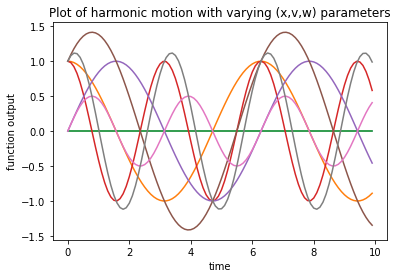

In [279]:
def harmonic_motion(t, x0,v0, w):
    return x0*np.cos(w*t) + (v0/w)*np.sin(w*t)

t = np.arange(0, 10, 0.1) 
v_list = np.arange(0, 2)
w_list = np.arange(1,3)
x0_list = np.arange(0,2)

permutes = [(x0,v0,w) for v0 in v_list for w in w_list for x0 in x0_list]

e1p2figure = plt.figure()
ax1 = e1p2figure.add_subplot()
for perm in permutes:
    ax1.plot(t, harmonic_motion(t, perm[0], perm[1],perm[2])) #label = ('x0 ='+ str(perm[0]),'v0 =' + str(perm[1]), 'w0 =' + str(perm[2])))
#e1p2figure.legend()
plt.xlabel('time')
plt.ylabel('function output')
ax1.set_title('Plot of harmonic motion with varying (x,v,w) parameters')



### Part 3

Equation (4) is not of the first order type, and can not be directly solved by our solver. We can work around this by modifying the equation.
We can think of this second order equation as a system of first order equations. first, we introduce a new variable
$ v=v(t)=x^{\prime}(t) $, and then we let: 
$$
\tag{6}
\vec{y}=
\begin{pmatrix}
x \\ 
v \\ 
\end{pmatrix}\,.
$$

We end up with:
$$
\begin{align}
\tag{7}
\frac{d\vec{y}}{dt} &=
\begin{pmatrix}
v \\ 
-\omega^2 x \\ 
\end{pmatrix} \,,
\end{align}
$$

Which is of the form as we defined in equation (1).
We can then set $v_0 = 0$, $x_0 =0 $, and $\omega = 1$ and give the following numeric solution:



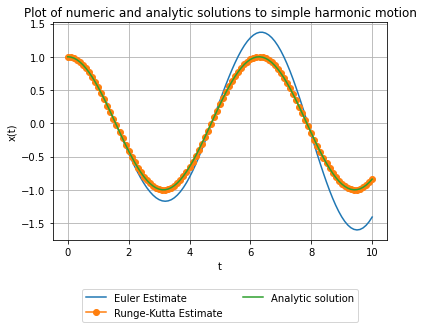

In [297]:

#Conditions 
dt = 0.1
x0 = 1
v0 = 0
y0 = (x0,v0)
w = 1
max_t = 10

def harmonic_vectorized(y_vec, dt):
    return np.array([y_vec[1],-w**2*y_vec[0]])

e1p3eulersol = ForwardEuler(harmonic_vectorized, y0, dt)
out1 = e1p3eulersol.solve(max_t)[1]
e1p3rungekutta = RungeKutta4(harmonic_vectorized, y0, dt)
out2 = e1p3rungekutta.solve(max_t)[1]


fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.plot(np.linspace(0,10,101),out1[:,0], label = 'Euler Estimate')
ax2.plot(np.linspace(0,10,101),out2[:,0], label = 'Runge-Kutta Estimate', marker ='o')
ax2.plot(np.linspace(0,10,101), harmonic_motion(np.linspace(0,10,101),1, 0,1), label = 'Analytic solution')
ax2.set_xlabel('t')
ax2.set_ylabel('x(t)')
ax2.grid()
ax2.set_title('Plot of numeric and analytic solutions to simple harmonic motion')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol= 2)


As we can see from the plot, the Runge-Kutta method follows the analytic solution almost exactly, while the Euler expectedly follows closely at the beginning but accumulates error along the input domain. 



## Exercise 2 No hope?

In this exercise we present the SZ-Model, a primary compartment model, which we use to model the spread of disease in a population. This model consists of defining the two populations $S$ and $Z$ which will denot the "Succeptible" human population and Zombie population.    

### Part 1 
We will now demonstrate how the solution to:

$$
\begin{align}
\tag{8}
\frac{\mathrm{d}S(t)}{\mathrm{d}t} =-\beta\cdot\frac{S(t)Z(t)}{N} \,.
\end{align}
$$

Which describes the change in Human population relative to zombie population and human population, and similarly, the evolution of the zombie population which is given by:
$$
\begin{align}
\tag{9}
\frac{\mathrm{d}Z(t)}{\mathrm{d}t} =+\beta\cdot\frac{S(t)Z(t)}{N} \,.
\end{align}
$$

is equal to:

$$
\begin{align}
\tag{10}
S(t) &=\frac{(S_0+Z_0)\frac{S_0}{Z_0}\exp(-\beta{t})}{1+\frac{S_0}{Z_0}\exp(-\beta{t})} \,, \\ 
\tag{11}
Z(t) &=\frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-\beta{t})}\,,
\end{align}
$$

where $S_0=S(0) $, $Z(0) = 1$, and $ S_0+Z_0=N $.


First, we can consider that the two equations $S(t)$ and $Z(t)$ both describe the proportion of a population N which is as either still a human or a zombie at time N. Hence, the two equations are related in the following way:  

$$
\begin{align}
\tag{13}
S(t) = N - Z(t) 
\end{align}
$$

and vice versa

$$
\begin{align}
\tag{14}
Z(t) = N - S(t) 
\end{align}
$$
Hence:

$$
\begin{align}
\tag{15}
\frac{\mathrm{d}S(t)}{\mathrm{d}t} = - \frac{\beta}{N}S(t)(N-S(t)) 
\end{align}
$$

$$
\begin{align}
\tag{16}
\frac{\mathrm{d}S(t)}{S(t)(N-S(t))} = - \frac{\beta}{N} \mathrm{d}t 
\end{align}
$$

$$
\begin{align}
\tag{16}
\int_{S_0}^{S}\frac{\mathrm{d}S}{S(N-S)} = -\int_{0}^{t} \frac{\beta}{N} \mathrm{d}t 
\end{align}
$$

Let's try to solve the left hand side integral by partial fraction decomposition:

$$
\begin{align}
\tag{17}
\frac{1}{S(N-S)} = \frac{A}{S} + \frac{B}{(N-S)} \rightarrow
\end{align}
$$

$$
\begin{align}
\tag{18}
A\cdot(N-S) + B\cdot S= 1
\end{align}
$$

Here we employ the fact that this relation should hold for any value of $S(t)$, hence we get the values for A and B when $S = 0$ and $S = N$ :

$$
\begin{align}
\tag{19}
A = B = \frac{1}{N}
\end{align}
$$

The left hand side integral can hence be written out as: 
$$
\begin{align}
\tag{20}
\int_{S_0}^{S}( \frac{1}{NS} + \frac{1}{N(N-S)})\mathrm{d}S   = \frac{1}{N }\int_{S_0}^{S}( \frac{1}{S} + \frac{1}{N-S})\mathrm{d}S
\end{align}
$$

Evaluating this, and the right hand side integral of equation 16, we can write:

$$
\begin{align}
\tag{21}
\frac{1}{N}[\mathrm{ln}(S) - \mathrm{ln}(N-S)]_{S_0}^{S} = -\frac{\beta}{N}[t]_{0}^{t}
\end{align}
$$

This can be solved for $S$:

$$
\begin{align}
\tag{22}
\frac{1}{N}[\mathrm{ln} (\frac{S}{N-S})]_{S_0}^{S} = -\frac{\beta}{N}[t]_{0}^{t}
\end{align}
$$

$$
\begin{align}
\tag{23}
\frac{1}{N} \mathrm{ln} (\frac{S(N-S_0)}{(N-S)S_0}) = -\frac{\beta}{N}t
\end{align}
$$

$$
\begin{align}
\tag{24}
\frac{S}{(N-S)} = \frac{S_0}{N-S_0}\cdot e^{-\beta t}
\end{align}
$$

Recall that $N-S_0 = Z_0$. This means that:
$$
\begin{align}
\tag{25}
\frac{S_0}{N- S_0} = \frac{S_0}{Z_0}
\end{align}
$$

We then get:

$$
\begin{align}
\tag{26}
S \cdot (\frac{S_0}{Z_0}\cdot e^{-\beta t})= N \frac{S_0}{Z_0}\cdot e^{-\beta t}
\end{align}
$$

$$
\begin{align}
\tag{27}
S = \frac{N \frac{S_0}{Z_0}\cdot e^{-\beta t}}{1+\frac{S_0}{Z_0}\cdot e^{-\beta t}}
\end{align}
$$

$$
\begin{align}
\tag{28}
S(t) = \frac{(S_0 +Z_0) \frac{S_0}{Z_0}\cdot e^{-\beta t}}{1+\frac{S_0}{Z_0}\cdot e^{-\beta t}}
\end{align}
$$

By repeating the same process we can write out equation (9) as: 


$$
\begin{align}
\tag{29}
\frac{\mathrm{d}Z(t)}{\mathrm{d}t} = \beta\cdot\frac{Z(t)(1-Z(t))}{N} 
\end{align}
$$

$$
\begin{align}
\tag{30}
\int_{Z_0}^{Z}\frac{\mathrm{d}Z}{Z(1-Z)} = \int_{0}^{t} \frac{\beta}{N} \mathrm{d}t
\end{align}
$$

Again, we utlilize the same partial fraction decomposition: 
$$
\begin{align}
\tag{31}
\frac{1}{N}  \int_{Z_0}^{Z}  \frac{1}{Z} +\frac{1}{1-Z} {\mathrm{d}Z} = \int_{0}^{t} \frac{\beta}{N} \mathrm{d}t \rightarrow
\end{align}
$$

$$
\begin{align}
\tag{32}
\frac{1}{N} \mathrm{ln} (\frac{Z(N-Z_0)}{(N-Z)Z_0}) = \frac{\beta}{N}t
\end{align}
$$


$$
\begin{align}
\tag{33}
\frac{Z(N-Z_0)}{(N-Z)Z_0} = e^{\beta t}
\end{align}
$$


$$
\begin{align}
\tag{34}
 \frac{Z}{N-Z}= \frac{Z_0}{N-Z_0} e^{\beta t}
\end{align}
$$

$$
\begin{align}
\tag{35}
Z(1 + \frac{Z_0}{N-Z_0} e^{\beta t}) = N \frac{Z_0}{N-Z_0} e^{\beta t}
\end{align}
$$


$$
\begin{align}
\tag{36}
Z = N \frac{Z_0}{S_0} \frac{e^{\beta t}}{(1+ \frac{Z_0}{S_0} e^{\beta t})} | \cdot \frac{ \frac{S_0}{Z_0} e^{-\beta t}}{\frac{S_0}{Z_0}e^{-\beta t}} \rightarrow
\end{align}
$$

$$
\begin{align}
\tag{37}
Z(t) &=\frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-\beta{t})}\,,
\end{align}
$$



### Part 2

Consider the limits as t goes to infinity for both functions:

$$
\begin{align}
\tag{38}
\mathrm{lim}_{t \rightarrow \infty} S(t) = \mathrm{lim}_{t \rightarrow \infty}  \frac{(S_0+Z_0)\frac{S_0}{Z_0}\exp(-\beta{t})}{1+\frac{S_0}{Z_0}\exp(-\beta{t})} -\rightarrow   \frac{(S_0 +Z_0)\frac{S_0}{Z_0}\cdot e^{-\infty}}{1+\frac{S_0}{Z_0}\cdot e^{-\infty}} = \frac{0}{1} = 0
\end{align}
$$

$$
\begin{align}
\tag{39}
\mathrm{lim}_{t \rightarrow \infty} Z(t) = \mathrm{lim}_{t \rightarrow \infty}  \frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-\beta{t})} \rightarrow \frac{S_0+Z_0}{1+\frac{S_0}{Z_0}\exp(-{\infty})} = \frac{S_0 + Z_0}{1} = N
\end{align}
$$




### Part 3
In this part we introduce the two smal villages Sokndal and Dirdal. We are interested in finding out what would happen if a zombie outbreak was to occur in these villages. 
First we plot the analytioc solutions with regards to Sokndal and Dirdals population and with a beta parameter of  $\beta =0.06 /h$ 

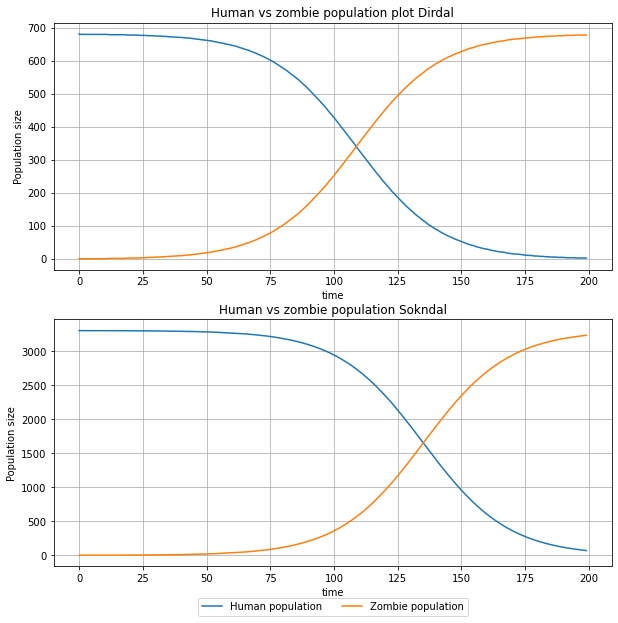

In [335]:
#Conditions
N_Dirdal = 683
N_Sokndal =3305
beta = 0.06
dt = 0.01
Z_0 = 1
Dirdal_S_0 = N_Dirdal - Z_0
Sokndal_S_0 = N_Sokndal - Z_0

Dirdal_SZvac_0 =(Dirdal_S_0,Z_0)
Sokndal_SZvec_0 = (Sokndal_S_0,Z_0)


def human_consentration(S_0,Z_0, t):
    """ Function that returns number of humans at a given time (given size, beta parameter and population. Rounds of value using numpy.astype(int)"""
    return np.array((S_0 + Z_0)*(S_0/Z_0)*np.exp(-beta*t)/(1+ (S_0/Z_0)*np.exp(-beta*t))).astype(int)


def zombie_consentration(S_0,Z_0, t):
    """ Function that returns number of zombies at a given time (given size, beta parameter and population. Rounds of value using numpy.astype(int)"""
    return np.array((S_0 +Z_0)/(1+(S_0/Z_0)*np.exp(-beta*t))).astype(int)


t = np.arange(0,200)
Dirdal_human_out = human_consentration(Dirdal_S_0,Z_0, t)
Dirdal_zombie_out =zombie_consentration(Dirdal_S_0,Z_0, t)
Sokndal_human_out = human_consentration(Sokndal_S_0,Z_0, t)
Sokndal_zombie_out =zombie_consentration(Sokndal_S_0,Z_0, t)

e2p3fig, e2p3axes = plt.subplots(2, figsize=(10,10))
e2p3axes[0].plot(t, Dirdal_human_out, label = 'Human population')
e2p3axes[0].plot(t,Dirdal_zombie_out, label = 'Zombie population')
e2p3axes[0].set_xlabel('time')
e2p3axes[0].set_ylabel('Population size')
e2p3axes[0].set_title('Human vs zombie population plot Dirdal')
e2p3axes[0].grid()


e2p3axes[1].plot(t,Sokndal_human_out, label = 'Human population')
e2p3axes[1].plot(t,Sokndal_zombie_out, label = 'Zombie population')
e2p3axes[1].grid()
e2p3axes[1].set_xlabel('time')
e2p3axes[1].set_ylabel('Population size')
e2p3axes[1].set_title('Human vs zombie population Sokndal')
e2p3axes[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.22), ncol= 2)

### Part 4

Here we utilize our implemented solver functions to find numeric solutions to the SZ-model, consiudering the cases of Dirdal and Sokndal.

In [439]:
#Conditions
N_Sokndal = 3305
N_Dirdal= 683
beta = 0.06
max_t = 300
dt = 30
t = np.array([i*dt for i in range(1+int(max_t/dt))]) # Same t range as the solver generates, for generating analytic solutions
Z0 = 0.1
S0_Dirdal = N_Dirdal - Z0
S0_Sokndal = N_Sokndal -Z0

SZ_vec0_Dirdal = (S0_Dirdal,Z0)
SZ_vec0_Sokndal = (S0_Sokndal,Z0)
 
dir_dSZ = SZ(beta0 = beta, N= N_Dirdal, lambda_rate = 0).dSZ     #Running instances of defined dSZ class
sok_dSZ = SZ(beta0 = beta, N= N_Sokndal, lambda_rate = 0).dSZ

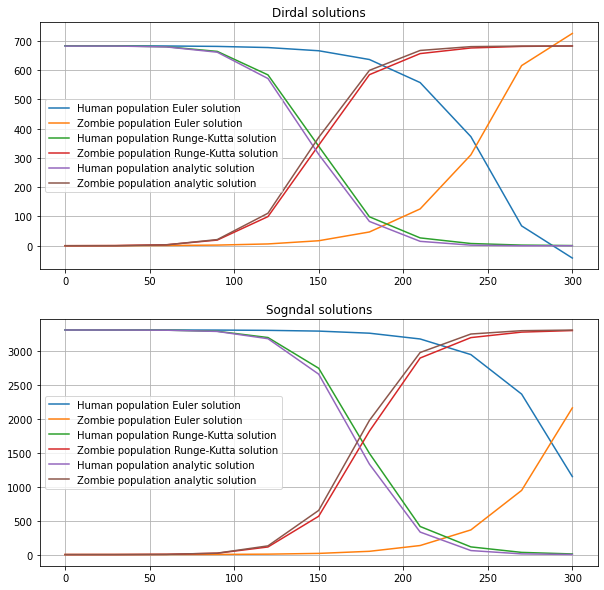

In [440]:


#Solver instances Dirdal
Dir_SZ_euler = ForwardEuler(dir_dSZ, SZ_vec0_Dirdal, dt)
Dir_SZ_euler_sol =Dir_SZ_euler.solve(max_t)
Dir_SZ_runge = RungeKutta4(dir_dSZ, SZ_vec0_Dirdal, dt)
Dir_SZ_runge_sol = Dir_SZ_runge.solve(max_t)
human_analytic_dirdal = human_consentration(S0_Dirdal,Z0, t)
zombie_analytic_dirdal = zombie_consentration(S0_Dirdal,Z0, t)

#Solver instances Sokndal
Sok_SZ_euler = ForwardEuler(sok_dSZ, SZ_vec0_Sokndal, dt)
Sok_SZ_euler_sol =Sok_SZ_euler.solve(max_t)
Sok_SZ_runge = RungeKutta4(sok_dSZ, SZ_vec0_Sokndal, dt)
Sok_SZ_runge_sol = Sok_SZ_runge.solve(max_t)
human_analytic_sokndal = human_consentration(S0_Sokndal,Z0, t)
zombie_analytic_sokndal = zombie_consentration(S0_Sokndal,Z0, t)



szfig, szaxes = plt.subplots(2, figsize =(10,10))
szaxes[0].plot(t,Dir_SZ_euler_sol[1][:,0], label = 'Human population Euler solution')
szaxes[0].plot(t,Dir_SZ_euler_sol[1][:,1], label = 'Zombie population Euler solution')
szaxes[0].plot(t,Dir_SZ_runge_sol[1][:,0], label = 'Human population Runge-Kutta solution')
szaxes[0].plot(t,Dir_SZ_runge_sol[1][:,1], label = 'Zombie population Runge-Kutta solution')
szaxes[0].plot(t,human_analytic_dirdal, label = 'Human population analytic solution')
szaxes[0].plot(t,zombie_analytic_dirdal, label ='Zombie population analytic solution')
szaxes[0].set_title('Dirdal solutions')
szaxes[0].legend()

szaxes[1].plot(t,Sok_SZ_euler_sol[1][:,0], label = 'Human population Euler solution')
szaxes[1].plot(t,Sok_SZ_euler_sol[1][:,1], label = 'Zombie population Euler solution')
szaxes[1].plot(t,Sok_SZ_runge_sol[1][:,0], label = 'Human population Runge-Kutta solution')
szaxes[1].plot(t,Sok_SZ_runge_sol[1][:,1], label = 'Zombie population Runge-Kutta solution')
szaxes[1].plot(t,human_analytic_sokndal, label = 'Human population analytic solution')
szaxes[1].plot(t,zombie_analytic_sokndal, label ='Zombie population analytic solution')
szaxes[1].set_title('Sogndal solutions')
szaxes[1].legend()
szaxes[1].grid()
szaxes[0].grid()



From experimenting with different step sizes, we found that the euler solution finds relatively accurate results when the step size is less than 1, with an almost exact match for dt = 0.1. However, the Runge-Kutta forth order solution seems to be as accurate as the annalytic solution for very crude resolutions, where splits between the plots of the analytic and Runge-kutta solution begins to form at stepsizes in the range of 20-30. 

Part 5


First we calculate the numerical value for: 

$$ \lambda = -\frac{1}{T} \cdot \mathrm{ln} (0.6)$$

when
$$ T_{Sokndal} = 48 h $$
and 
$$ T_{Dirdal} = 72 h$$

In [450]:
lambda_sokndal = -np.log(0.6)*(48)**(-1)
lambda_dirdal = -np.log(0.6)*(72)**(-1)

print('Lambda rate for Sogndal =' ,lambda_sokndal, 'Rate value for Dirdal = ', lambda_dirdal)

Lambda rate for Sogndal = 0.010642200495124807 Rate value for Dirdal =  0.007094800330083204


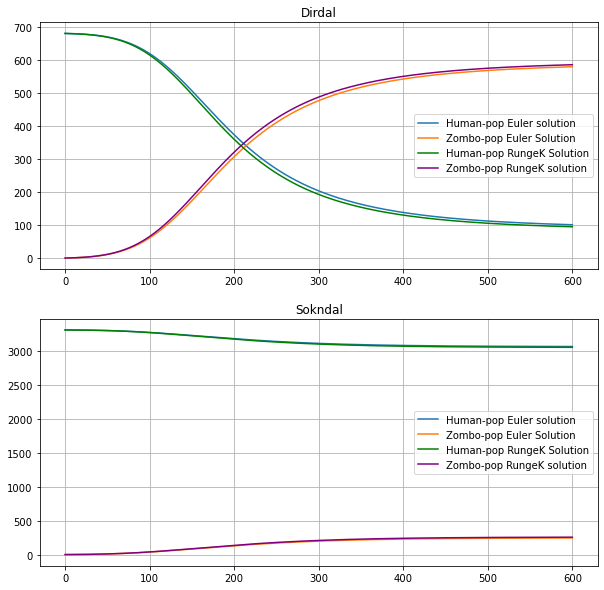

In [474]:
#Setup conditions (AGAIN)
#Conditions
N_Sokndal = 3305
N_Dirdal= 683
beta0 = 0.06
max_t = 600
dt = 1
Z0 = 1
S0_Dirdal = N_Dirdal - Z0
S0_Sokndal = N_Sokndal -Z0
y0_dirdal = (S0_Dirdal, Z0)
y0_sokndal = (S0_Sokndal, Z0)

lambda_rate = lambda_dirdal


t = np.array([i*dt for i in range(1+int(max_t/dt))])


neo_dSZ_dirdal = SZ(beta0 = beta0,lambda_rate = lambda_dirdal, N = N_Dirdal).neo_dSZ 
neo_dSZ_sokndal = SZ(beta0 = beta0,lambda_rate = lambda_sokndal, N = N_Sokndal).neo_dSZ

#Generating Numeric solution Dirdal
dir_neo_euler = ForwardEuler(neo_dSZ_dirdal,y0_dirdal, dt)
dir_neo_euler_sol = dir_neo_euler.solve(max_t)
dir_neo_runge = RungeKutta4(neo_dSZ_dirdal, y0_dirdal, dt)
dir_neo_runge_sol = dir_neo_runge.solve(max_t)

#Generating Numeric solution Sokndal
sok_neo_euler = ForwardEuler(neo_dSZ_sokndal,y0_sokndal, dt)
sok_neo_euler_sol = sok_neo_euler.solve(max_t)
sok_neo_runge = RungeKutta4(neo_dSZ_sokndal, y0_sokndal, dt)
sok_neo_runge_sol = sok_neo_runge.solve(max_t)



#PLOTTING
e2p5fig, p5ax = plt.subplots(2,1, figsize = (10,10))
p5ax[0].plot(dir_neo_euler_sol[0], dir_neo_euler_sol[1][:,0], label ='Human-pop Euler solution')
p5ax[0].plot(dir_neo_euler_sol[0],dir_neo_euler_sol[1][:,1], label ='Zombo-pop Euler Solution')
p5ax[0].plot(dir_neo_runge_sol[0],dir_neo_runge_sol[1][:,0], label ='Human-pop RungeK Solution', color ='green')
p5ax[0].plot(dir_neo_runge_sol[0],dir_neo_runge_sol[1][:,1], label ='Zombo-pop RungeK solution',color ='purple')
p5ax[0].set_title('Dirdal')
p5ax[0].grid()
p5ax[0].legend()
p5ax[1].plot(sok_neo_euler_sol[0],sok_neo_euler_sol[1][:,0], label = 'Human-pop Euler solution')
p5ax[1].plot(sok_neo_euler_sol[0],sok_neo_euler_sol[1][:,1], label ='Zombo-pop Euler Solution')
p5ax[1].plot(sok_neo_runge_sol[0],sok_neo_runge_sol[1][:,0], label ='Human-pop RungeK Solution' ,color ='green')
p5ax[1].plot(sok_neo_runge_sol[0],sok_neo_runge_sol[1][:,1],label ='Zombo-pop RungeK solution', color ='purple')
p5ax[1].legend()
p5ax[1].set_title('Sokndal')
p5ax[1].grid()

In [476]:
#Timing Dirdal
%timeit dir_neo_euler_sol = dir_neo_euler.solve(max_t)
%timeit dir_neo_runge_sol = dir_neo_runge.solve(max_t)

# Sokndal
%timeit sok_neo_euler_sol = sok_neo_euler.solve(max_t)
%timeit sok_neo_runge_sol = sok_neo_runge.solve(max_t)

4.79 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.5 ms ± 64.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.82 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.8 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Again, from the plot we can see that in Dirdal, about a 100 people will survive the attack, while about 3000 people will survie in Sokndal. We can see some deviation from between the two numeric schemes start to apperar with a step size of 1. Hpwever, we can also see that the Runge-Kutta approach takes a while longer to execute, with execution times around 4 times slower than the euler method. 


## Exercise 3 Counter Strike 
note: (actual counter strike, not the videogame series)

### The SEZR- model:
$$
\begin{align}

\frac{\mathrm{d}S(t)}{\mathrm{d}t} &= -\beta(t)\cdot\frac{S(t)Z(t)}{N} \,, \\ 

\frac{\mathrm{d}E(t)}{\mathrm{d}t} &= \beta(t)\cdot\frac{S(t)Z(t)}{N}-\sigma\cdot{E(t)} \,, \\ 

\frac{\mathrm{d}Z(t)}{\mathrm{d}t} &= \sigma\cdot{E(t)}-\left(\alpha+\omega(t)\right)\frac{S(t)Z(t)}{N} \,, \\ 

\frac{\mathrm{d}R(t)}{\mathrm{d}t} &= \left(\alpha+\omega(t)\right)\frac{S(t)Z(t)}{N} \,.
\end{align}
$$

Where: $S$ and $Z$ as before refer to the human and zombie population, while $E$ and $R$ denotes number of exposed humans, and number of deceased zombies respectively.


We  define the attack function $\omega$:
$$
\begin{equation}
\omega(t) = a\displaystyle\sum_{i=1}^m
\exp\left(-\frac{1}{2}(\frac{t-T_i}{T_\sigma})^2\right)\,,
\end{equation}
$$

Where 
where $ a $ and $T_{\sigma}$ are constant parameters, and where
$T_1, T_2, \ldots, T_m$ are the times at which the humans launch
violent attacks.


We also define the basic reproduction number $\mathcal{R}$ as the average rate of new infected in a population.
For the SEZR-model, a good approximation to this number can be expressed as: 
$$
\begin{equation}
\tag{20}
\mathcal{R}_0\simeq\frac{\beta(t)}{\alpha + \omega(t)}.
\end{equation}
$$


### Part 1

Here we implement the attack function $\omega (t)$ 


In [501]:
#Setup conditions (AGAIN)
beta_0 =0.06
max_t = 350
a = 40*beta_0
T_sigma = 1

t = np.array([i*dt for i in range(1+int(max_t/dt))]) 

def omega(t, a):
    """function that calculates attack function of t"""     
    T_vec = np.array([100,300])
    val = 0
    for i in T_vec:
         val += a*np.exp(-0.5*((t- i)/T_sigma)**2)
    return val

omegas = omega(t, a)




Plotting attack function with $ a = 40 \cdot \beta_0$ and $T_{\sigma} = 1$. We also create an array of $T$ attack-time values. 
We can see that the aptly named $T_{\sigma}$ value sets the standard deviation for these bell-curves, which logically would correspond to the effectivenes of the attack, the steeper the bell-curve, the quicker the attack takes effect. $a$, denotes the size of the attack, when we increase a more zombies are killed in the attack. 

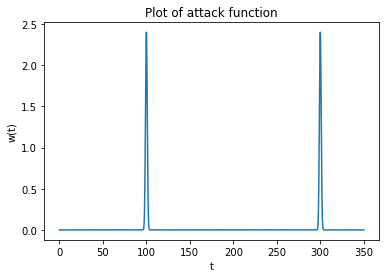

In [502]:
e3p1fig, e3p1ax = plt.subplots()
e3p1ax.set_title('Plot of attack function')
e3p1ax.set_xlabel('t')
e3p1ax.set_ylabel('w(t)')
e3p1ax.plot(t,omegas)

We can see that the function is a sort of sum of gaussian bell curves, which makes sense considering the attack formula. We can see that these curves peak at the values where $t = T_i$. 

### Part 2

In this part we implement and run the SEZR model for Dirdal, including the violent attack function.

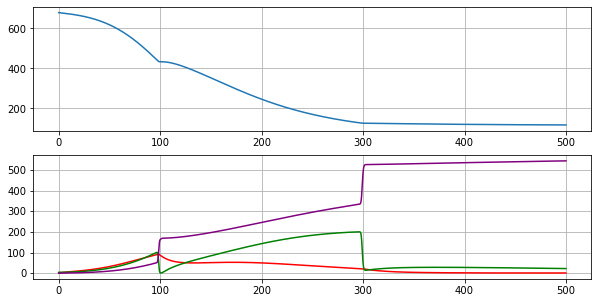

In [505]:
T_vec = np.array([100,300])
t = np.array([i*dt for i in range(1+int(max_t/dt))])

Z0 = 4
S0 = N - Z0
E0 = 2
R0 = 0
SEZR_vec_0 = (S0,E0,Z0,R0)
N = 683
max_t = 500
dt = 0.1
beta_0 = 0.15
lambda_rate = lambda_dirdal


def dSEZR(SEZR_vec, t):
    """ New d(S,E,Z,R)/dt vector function, with new beta-function"""
   #### SETUP  
    T_sigma = 1
    alpha = 0.02
    a = 40*beta_0
    om = omega(t, a)
    
   
   
    if SEZR_vec[2] >= 1:
        beta = beta_0*np.exp(-t*lambda_rate) 
    else:
        beta = 0

    if SEZR_vec[1] >= 1:
        sigma = 1/24
    else:
        sigma = 0
    
  

    dS = (-beta/N)*SEZR_vec[0]*SEZR_vec[2]
    dE = (beta/N)*SEZR_vec[0]*SEZR_vec[2] - sigma*SEZR_vec[1]
    dZ = sigma*SEZR_vec[1] - (alpha + om)*(N**(-1))*SEZR_vec[0]*SEZR_vec[2]
    dR = (alpha + om)*(N**(-1))*SEZR_vec[0]*SEZR_vec[2]
    return np.array([dS,dE,dZ,dR])

attempt = RungeKutta4(dSEZR, SEZR_vec_0, dt)
attempt_sol = attempt.solve(max_t)[1]

e3p2fig, e3p2ax = plt.subplots(2, figsize = (10,5))
e3p2ax[0].plot(t, attempt_sol[:,0], )
e3p2ax[0].grid()
e3p2ax[1].plot(t, attempt_sol[:,1], color = 'red')
e3p2ax[1].plot(t, attempt_sol[:,2], color = 'green')
e3p2ax[1].plot(t, attempt_sol[:,3], color = 'purple')
e3p2ax[1].grid()


We se that when $\frac{\beta}{\alpha} >1$ it is still possible to survive. Par example: When we have $\alpha = 0.02$ and $\beta = 0.06$ and hence a ratio of $\frac{\beta}{\alpha} = 3$ the number of non-infected humans stabilizes at roughly 600 people (for Dirdal). 

We can see that when turning on the violent attack function: We obtain interspersed periods of rapid decline in zombie populaiton at the time points where the attacks occur (WHich is makes sence as this is what a voilent attack towards the zombie populaiton entices)

## Exercise 4 Compartment model for Covid-19

In this last exercise we apply the what we have learned from the previous exercises to the real world example of the currently ongoing COVID-19 epidemic. We define the SEIRD model and fit this model to data collected from various contries prioer to the onset of the covid crisis.  

### The SEIRD-model.
We deinfe the SEIRD model as:

$$
\begin{align}
\tag{}
\frac{\mathrm{d}S(t)}{\mathrm{d}t} &= -\beta(t)\cdot\frac{S(t)I(t)}{N} \,, \\ 
\tag{}
\frac{\mathrm{d}E(t)}{\mathrm{d}t} &= \beta(t)\cdot\frac{S(t)I(t)}{N}-\sigma\cdot{E(t)} \,, \\ 
\tag{}
\frac{\mathrm{d}I(t)}{\mathrm{d}t} &= \sigma\cdot{E(t)}-\gamma\cdot I(t) \,, \\ 
\tag{}
\frac{\mathrm{d}R(t)}{\mathrm{d}t} &= (1-f)\cdot\gamma\cdot I(t) \,, \\ 
\tag{}
\frac{\mathrm{d}D(t)}{\mathrm{d}t} &= f\cdot\gamma\cdot I(t)\,.
\end{align}
$$

Where $S$ as before denotes the part of the population which is "succeptible" to infection, $E$ denotes the number of people that are exposed to the virus, $I$ is the number of infected, $R$ is the number of recoveries while $D$ denotes the death toll. 

### Part 1

#### a)

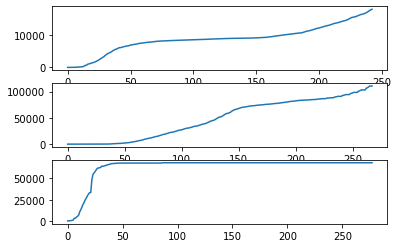

In [487]:
covidfile = pd.read_csv('data\corona_data.dat', sep ='\t')

Norway_data = covidfile.loc[covidfile['LOCATION'] == 'Norway']
Sweden_data = covidfile.loc[covidfile['LOCATION'] == 'Sweden']
Hubei_data = covidfile.loc[covidfile['LOCATION'] == 'Hubei']

covid_dta_fig, cov_ax = plt.subplots(3,1)
cov_ax[0].plot(Norway_data['ELAPSED_TIME_SINCE_OUTBREAK'],Norway_data['CONFIRMED'])
cov_ax[1].plot(Sweden_data['ELAPSED_TIME_SINCE_OUTBREAK'],Sweden_data['CONFIRMED'])
cov_ax[2].plot(Hubei_data['ELAPSED_TIME_SINCE_OUTBREAK'],Hubei_data['CONFIRMED'])

### Part 2



In [142]:
### approach where we fit the solved system of equations to the data



def data_wrangler(Data, location, N):
    """function that retrieves relevant data from the file, given the Original population of the location the input data describes"""
    
    country_data = Data.loc[Data['LOCATION'] == location]

    time_data = country_data['ELAPSED_TIME_SINCE_OUTBREAK'].to_numpy()

    S_data =N - country_data['CONFIRMED']  # #Assume that the number of "Susceptible " is equall to population - confirmed cases e.g: no re-infection
    I_data = country_data['CONFIRMED'] - country_data['RECOVERED'] - country_data['DEATHS']
    R_data = country_data['RECOVERED']
    D_data = country_data['DEATHS']

    n_array_for_fixing_size_troubles = np.zeros_like(time_data)
    n_array_for_fixing_size_troubles[0] = N
    return np.array([n_array_for_fixing_size_troubles, time_data,S_data,I_data,R_data,D_data])


def function_to_be_fitted(wrangeled_data,b_0, lam_pa):
    """Function that "takes in data" and outputs a numerical solution instance of the SEIRD model, note that 
    the class solver generates its own x(t/input) values, and we do not use the data as direct input to ythe solution. This solution will then only work 
    if the x (t) values are evenly spaced in the data """
    max_t = len(wrangeled_data[1]) -1
    dt = wrangeled_data[1][1] - wrangeled_data[1][0]           #Assumes dt is equall to first timestep
    
    s0 = wrangeled_data[0][0] -1
    e0,i0,r0,d0 =0,1,0,0
    y0 =(s0,e0,i0,r0,d0)

    seird_instance = SEIRD(N=5.85e7, sigma=1/5.1, gamma = 1/20, death_rate =0.05).dSEIRD_setup(b_0,lam_pa)

    runge_instance =RungeKutta4(seird_instance, y0, dt)
    instance_sol = runge_instance.solve(max_t)

    return np.sum(instance_sol[1][:,2:], axis =1) #sum of calculated I,R and D, this sum should match the total recorded cases of the data file when fitted 
    

N = 5.85e7       #Current Hubei population acording to wikipedia
test_wrangeled = data_wrangler(covidfile, 'Hubei',N)


#Curve fitting
popt, devs = opt.curve_fit(function_to_be_fitted,test_wrangeled, Hubei_data['CONFIRMED'])
print(popt)



[15.75982686  0.26911914]


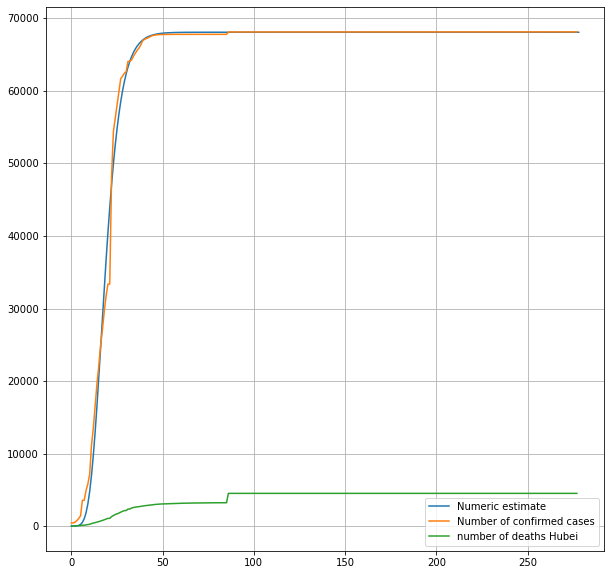

In [223]:
Seird_to_be_plotted = SEIRD().dSEIRD_setup(popt[0],popt[1])
Hubei_SEIRD = RungeKutta4(Seird_to_be_plotted,(5.85e7-1,0,1,0,0), 1)
Hubei_SEIRD_sol = Hubei_SEIRD.solve(278)

hubeifig, hubaxe = plt.subplots(figsize=(10,10))
hubaxe.grid()
hubaxe.plot(Hubei_SEIRD_sol[0], np.sum(Hubei_SEIRD_sol[1][:,2:], axis =1), label ='Numeric estimate')
hubaxe.plot(test_wrangeled[1],np.sum(test_wrangeled[3:], axis =0), label ='Number of confirmed cases')
hubaxe.plot(test_wrangeled[1],test_wrangeled[5], label = 'number of deaths Hubei')
plt.legend()



### Part 3

Part 4

[15.75982686  0.26911914] [2.63640826 0.01645156] [19.24954589  0.07268695]


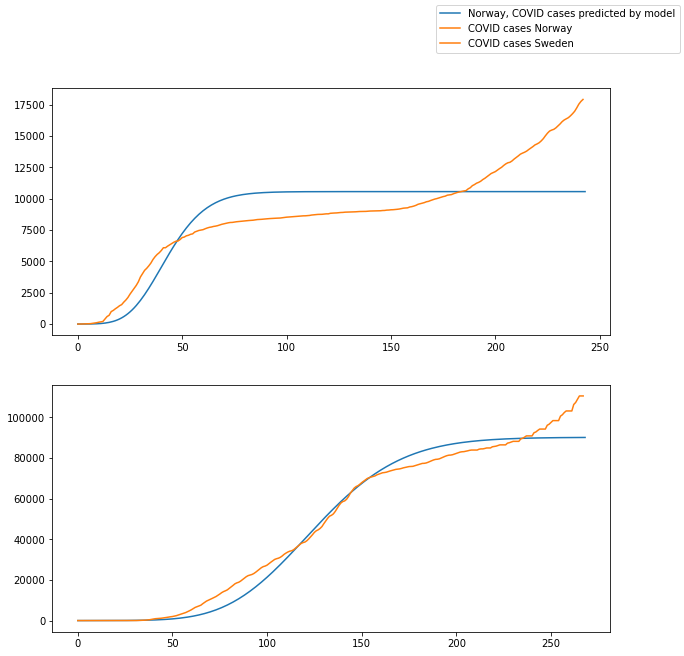

In [478]:

### Lets try fitting norway and sweden to data: 

N_Norway = 5.42e6
noray_wrangeled = data_wrangler(covidfile, location='Norway', N = N_Norway)
normaxt = len(noray_wrangeled[0])
norpopt, norvar = opt.curve_fit(function_to_be_fitted, noray_wrangeled, Norway_data['CONFIRMED'])

N_sweden = 1.01e7
swede_wrangle = data_wrangler(covidfile, location='Sweden', N= N_sweden) 
swedemaxt = len(swede_wrangle[0])
swedpopt, swedvar = opt.curve_fit(function_to_be_fitted, swede_wrangle, Sweden_data['CONFIRMED'])


Norway_Seird_to_be_plotted = SEIRD().dSEIRD_setup(norpopt[0],norpopt[1])
Norway_SEIRD = RungeKutta4(Norway_Seird_to_be_plotted,(N_Norway-1,0,1,0,0), 1)
Norway_SEIRD_sol = Norway_SEIRD.solve(normaxt)

Sweden_seird_to_be_uknow = SEIRD().dSEIRD_setup(swedpopt[0],swedpopt[1])
Sweden_SEIRD = RungeKutta4(Sweden_seird_to_be_uknow,(N_sweden-1,0,1,0,0), 1)
Sweden_SEIRD_sol = Sweden_SEIRD.solve(swedemaxt)

scandinaviafig, scanaxe = plt.subplots(2, figsize=(10,10))
scanaxe[0].plot(Norway_SEIRD_sol[0], np.sum(Norway_SEIRD_sol[1][:,2:], axis =1), label = 'Norway, COVID cases predicted by model')
scanaxe[0].plot(noray_wrangeled[1],np.sum(noray_wrangeled[3:], axis = 0), label = 'COVID cases Norway')
scanaxe[1].plot(Sweden_SEIRD_sol[0], np.sum(Sweden_SEIRD_sol[1][:,2:], axis =1))
scanaxe[1].plot(swede_wrangle[1],np.sum(swede_wrangle[3:], axis = 0), label = 'COVID cases Sweden')
scandinaviafig.legend()

print(popt,swedpopt, norpopt)